In [28]:
# parse
import re
loss_regex = r"TrainLoss: (\d+\.\d+)"
tp_regex = r": (\d+\.\d) img\/sec"
comp_regex = r"Bandwidth savings: from \d+ to \d+ \((\d+\.\d+)x\)"

def parse(file, regex):
    nums = []
    for line in open(file, "r").readlines():
        matches = re.search(regex, line)
        if matches:
            nums.append(float(matches.group(1)))
    return nums

def parse_loss(file):
    return parse(file, loss_regex)

def parse_tp(file):
    return parse(file, tp_regex)

def parse_comp_ratio(file):
    return parse(file, comp_regex)

In [32]:
from os import listdir
benchmarks = {}

for name in listdir("benchmarks"):
    file = f"benchmarks/{name}"
    attrs = {}
    attrs["loss"] = parse_loss(file)
    attrs["tp"] = parse_tp(file)
    attrs["label"] = name
    
    comp = parse_comp_ratio(file)
    if len(comp) > 0:
        attrs["comp"] = comp[0]

    attrs["label"] = name
    if "comp" in attrs:
        attrs["label"] += f" (ratio: {attrs['comp']:.0f})"

    benchmarks[name] = attrs

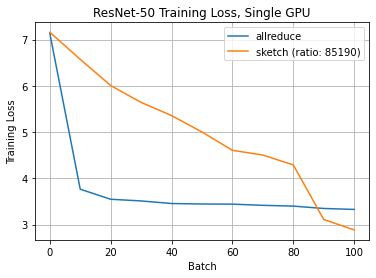

In [33]:
import numpy as np
import matplotlib.pyplot as plt
t = np.arange(0, 110, 10)
for name, attrs in benchmarks.items():
    plt.plot(t, attrs["loss"], label=attrs["label"])

plt.xlabel("Batch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.legend()
plt.title("ResNet-50 Training Loss, Single GPU")

plt.show()

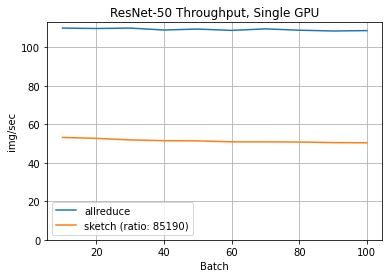

In [34]:
t = np.arange(10, 110, 10)

for name, attrs in benchmarks.items():
    plt.plot(t, attrs["tp"], label=attrs["label"])

plt.xlabel("Batch")
plt.ylabel("img/sec")
plt.grid(True)
plt.legend()
plt.title("ResNet-50 Throughput, Single GPU")
plt.ylim(bottom=0)

plt.show()